<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# Dilated Convolutional Neural Network (CNN)

This notebook introduces Dilated Convolutional Neural Network (CNN) model and carries out multi-round training and evaluation of this model on the Orange Juice dataset.

The Dilated CNN is built upon dilated causal convolution inspired by [WaveNet](https://arxiv.org/abs/1609.03499). [Recently study](https://arxiv.org/abs/1803.01271) shows that it outperforms canonical recurrent networks such as LSTMs over a diverse range of tasks and datasets. Dilated CNN has many advantages when handling sequential data like time series
* Capturing long-range input information with less parameters
* Handling temporal flow with causal connection structures
* Better training efficiency than recurrent neural networks

Dilated CNN has been applied in several machine learning competitions and achieved impressive performance, e.g. [the Favorita Grocery Sales Forecasting competition](https://github.com/LenzDu/Kaggle-Competition-Favorita).

## Global Settings and Imports

In [1]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2
#%matplotlib inline

In [2]:
# %load_ext blackcellmagic

In [3]:
import os

# import sys
# import time
import math

import subprocess
import random
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import optimizers

# from tensorflow.keras.layers import *
from tensorflow.keras.layers import (
    Input,
    Lambda,
    Embedding,
    Conv1D,
    Dropout,
    Flatten,
    Dense,
    concatenate,
)
from tensorflow.keras.models import Model, load_model

# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
from fclib.common.utils import git_repo_path
from fclib.dataset.ojdata import download_ojdata, split_train_test, FIRST_WEEK_START
from fclib.feature_engineering.feature_utils import (
    week_of_month,
    df_from_cartesian_product,
    gen_sequence_array,
    static_feature_array,
    normalize_dataframe,
)

## Parameters

In [5]:
# Use False if you've already downloaded and split the data
DOWNLOAD_SPLIT_DATA = False  # True

# # Data directory
# DATA_DIR = os.path.join(git_repo_path(), "ojdata")

# Forecasting settings
N_SPLITS = 10
HORIZON = 2
GAP = 2
FIRST_WEEK = 40
LAST_WEEK = 156

In [6]:
# Data paths
DATA_DIR = os.path.join(git_repo_path(), "ojdata")
SUBMISSION_DIR = "."
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Data parameters
MAX_STORE_ID = 137
MAX_BRAND_ID = 11

# Parameters of the model
PRED_HORIZON = 3
PRED_STEPS = 2
SEQ_LEN = 15
DROPOUT_RATE = 0.01
DYNAMIC_FEATURES = ["deal", "feat", "month", "week_of_month", "price", "price_ratio"]
STATIC_FEATURES = ["store", "brand"]

# Parameters of training algorithm
BATCH_SIZE = 64
LEARNING_RATE = 0.015
EPOCHS = 25

## Data Preparation

In [7]:
if DOWNLOAD_SPLIT_DATA:
    download_ojdata(DATA_DIR)
    split_train_test(
        DATA_DIR,
        n_splits=N_SPLITS,
        horizon=HORIZON,
        gap=GAP,
        first_week=FIRST_WEEK,
        last_week=LAST_WEEK,
        write_csv=True,
    )
    print("Finished data downloading and splitting.")

In [8]:
# Utility functions
def plot_result(results, store, brand):
    """Plot out prediction results and actual sales.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
        store (integer): store index
        brand (integer): brand index
        
    Returns:
        None
    """
    subset = results[(results.store == store) & (results.brand == brand)]
    subset = subset[["week", "prediction", "actual"]].set_index("week")
    ax = subset.plot()
    ax.set_title("Forecast result of brand {} at store {}".format(brand, store))
    ax.set_ylabel("unit sales")
    ax.set_ylim(bottom=0)
    ax.legend(labels=["predicted", "actual"])

In [9]:
# Model definition
def create_dcnn_model(seq_len, kernel_size=2, n_filters=3, n_input_series=1, n_outputs=1):
    """Create a Dilated CNN model.

    Args: 
        seq_len (Integer): Input sequence length
        kernel_size (Integer): Kernel size of each convolutional layer
        n_filters (Integer): Number of filters in each convolutional layer
        n_outputs (Integer): Number of outputs in the last layer

    Returns:
        Keras Model object
    """
    # Sequential input
    seq_in = Input(shape=(seq_len, n_input_series))

    # Categorical input
    cat_fea_in = Input(shape=(2,), dtype="uint8")
    store_id = Lambda(lambda x: x[:, 0, None])(cat_fea_in)
    brand_id = Lambda(lambda x: x[:, 1, None])(cat_fea_in)
    store_embed = Embedding(MAX_STORE_ID + 1, 7, input_length=1)(store_id)
    brand_embed = Embedding(MAX_BRAND_ID + 1, 4, input_length=1)(brand_id)

    # Dilated convolutional layers
    c1 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=1, padding="causal", activation="relu")(
        seq_in
    )
    c2 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=2, padding="causal", activation="relu")(c1)
    c3 = Conv1D(filters=n_filters, kernel_size=kernel_size, dilation_rate=4, padding="causal", activation="relu")(c2)

    # Skip connections
    c4 = concatenate([c1, c3])

    # Output of convolutional layers
    conv_out = Conv1D(8, 1, activation="relu")(c4)
    conv_out = Dropout(DROPOUT_RATE)(conv_out)
    conv_out = Flatten()(conv_out)

    # Concatenate with categorical features
    x = concatenate([conv_out, Flatten()(store_embed), Flatten()(brand_embed)])
    # x = BatchNormalization()(x)
    # x = Dense(64, activation='relu')(x)
    # x = Dropout(0.2)(x)
    x = Dense(16, activation="relu")(x)
    # x = Dropout(0.2)(x)
    output = Dense(n_outputs, activation="linear")(x)

    # Define model interface, loss function, and optimizer
    model = Model(inputs=[seq_in, cat_fea_in], outputs=output)

    return model


model = create_dcnn_model(seq_len=SEQ_LEN, n_input_series=1 + len(DYNAMIC_FEATURES), n_outputs=PRED_STEPS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 7)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 15, 3)        45          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15, 3)        21          conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 15, 3)        21          conv1d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
# Fix random seeds
np.random.seed(4)
random.seed(4)
tf.random.set_seed(4)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train models and make predictions
pred_all = []
combined_all = []
metric_all = []
file_name = os.path.join(SUBMISSION_DIR, "dcnn_model.h5")
for r in range(2):  # range(N_SPLITS):
    print("---- Round " + str(r + 1) + " ----")
    offset = 0 if r == 0 else 40 + r * PRED_STEPS
    # Load training data
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, "train_" + str(r + 1) + ".csv"))
    train_df["move"] = train_df["logmove"].apply(lambda x: round(math.exp(x)))
    # print(train_df.head(3))
    # print('')
    train_df = train_df[["store", "brand", "week", "move"]]

    # Create a dataframe to hold all necessary data
    store_list = train_df["store"].unique()
    brand_list = train_df["brand"].unique()
    train_end_week = train_df["week"].max()
    week_list = range(FIRST_WEEK + offset, train_end_week + GAP + HORIZON)
    d = {"store": store_list, "brand": brand_list, "week": week_list}
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how="left", on=["store", "brand", "week"])

    # Get future price, deal, and advertisement info
    aux_df = pd.read_csv(os.path.join(TRAIN_DIR, "aux_" + str(r + 1) + ".csv"))
    data_filled = pd.merge(data_filled, aux_df, how="left", on=["store", "brand", "week"])
    # print('Number of missing rows is {}'.format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
    # print('')

    # Create relative price feature
    price_cols = [
        "price1",
        "price2",
        "price3",
        "price4",
        "price5",
        "price6",
        "price7",
        "price8",
        "price9",
        "price10",
        "price11",
    ]
    data_filled["price"] = data_filled.apply(lambda x: x.loc["price" + str(int(x.loc["brand"]))], axis=1)
    data_filled["avg_price"] = data_filled[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
    data_filled["price_ratio"] = data_filled["price"] / data_filled["avg_price"]
    data_filled.drop(price_cols, axis=1, inplace=True)

    # Fill missing values
    data_filled = data_filled.groupby(["store", "brand"]).apply(
        lambda x: x.fillna(method="ffill").fillna(method="bfill")
    )
    # print(data_filled.head(3))
    # print('')

    # Create datetime features
    data_filled["week_start"] = data_filled["week"].apply(
        lambda x: FIRST_WEEK_START + datetime.timedelta(days=(x - 1) * 7)
    )
    # data_filled['year'] = data_filled['week_start'].apply(lambda x: x.year)
    data_filled["month"] = data_filled["week_start"].apply(lambda x: x.month)
    data_filled["week_of_month"] = data_filled["week_start"].apply(lambda x: week_of_month(x))
    data_filled["day"] = data_filled["week_start"].apply(lambda x: x.day)
    data_filled.drop("week_start", axis=1, inplace=True)

    # Normalize the dataframe of features
    cols_normalize = data_filled.columns.difference(["store", "brand", "week"])
    data_scaled, min_max_scaler = normalize_dataframe(data_filled, cols_normalize)
    # data_scaled.head()

    # Create sequence array for 'move'
    start_timestep = 0
    end_timestep = train_end_week - FIRST_WEEK - PRED_HORIZON
    train_input1 = gen_sequence_array(
        data_scaled, SEQ_LEN, ["move"], "store", "brand", start_timestep, end_timestep - offset
    )
    # train_input1.shape

    # Create sequence array for other dynamic features
    start_timestep = PRED_HORIZON
    end_timestep = train_end_week - FIRST_WEEK
    train_input2 = gen_sequence_array(
        data_scaled, SEQ_LEN, DYNAMIC_FEATURES, "store", "brand", start_timestep, end_timestep - offset
    )
    # train_input2.shape

    seq_in = np.concatenate((train_input1, train_input2), axis=2)
    # seq_in.shape

    # Create array of static features
    total_timesteps = train_end_week - FIRST_WEEK - SEQ_LEN - PRED_HORIZON + 2
    cat_fea_in = static_feature_array(data_filled, total_timesteps - offset, STATIC_FEATURES)
    # cat_fea_in.shape

    # Create training output
    start_timestep = SEQ_LEN + PRED_HORIZON - PRED_STEPS
    end_timestep = train_end_week - FIRST_WEEK
    train_output = gen_sequence_array(
        data_filled, PRED_STEPS, ["move"], "store", "brand", start_timestep, end_timestep - offset
    )
    train_output = np.squeeze(train_output)
    # train_output.shape

    # Create and train model
    if r == 0:
        model = create_dcnn_model(
            seq_len=SEQ_LEN, n_filters=2, n_input_series=1 + len(DYNAMIC_FEATURES), n_outputs=PRED_STEPS
        )
        adam = optimizers.Adam(lr=LEARNING_RATE)
        model.compile(loss="mape", optimizer=adam, metrics=["mape"])
        # Define checkpoint and fit model
        checkpoint = ModelCheckpoint(file_name, monitor="loss", save_best_only=True, mode="min", verbose=1)
        callbacks_list = [checkpoint, tensorboard_callback]
        history = model.fit(
            [seq_in, cat_fea_in],
            train_output,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=callbacks_list,
            verbose=1,
        )
    else:
        model = load_model(file_name)
        checkpoint = ModelCheckpoint(file_name, monitor="loss", save_best_only=True, mode="min", verbose=1)
        callbacks_list = [checkpoint]
        history = model.fit(
            [seq_in, cat_fea_in], train_output, epochs=1, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1
        )

    # Get expected test output
    test_df = pd.read_csv(os.path.join(TEST_DIR, "test_" + str(r + 1) + ".csv"))
    test_df["actual"] = test_df["logmove"].apply(lambda x: round(math.exp(x)))
    test_df.drop("logmove", axis=1, inplace=True)

    exp_output = data_filled[data_filled.week >= train_end_week + GAP].reset_index(drop=True)
    exp_output = exp_output[["store", "brand", "week"]]
    exp_output = pd.merge(exp_output, test_df, on=["store", "brand", "week"], how="left")

    start_timestep = 0
    end_timestep = PRED_STEPS - 1
    exp_test_output = gen_sequence_array(
        exp_output, PRED_STEPS, ["actual"], "store", "brand", start_timestep, end_timestep
    )
    exp_test_output = np.squeeze(exp_test_output)

    # Get inputs for prediction
    start_timestep = train_end_week + GAP - FIRST_WEEK - SEQ_LEN - PRED_HORIZON + PRED_STEPS
    end_timestep = train_end_week + GAP - FIRST_WEEK + PRED_STEPS - 1 - PRED_HORIZON
    test_input1 = gen_sequence_array(
        data_scaled, SEQ_LEN, ["move"], "store", "brand", start_timestep - offset, end_timestep - offset
    )

    start_timestep = train_end_week + GAP + HORIZON - FIRST_WEEK - SEQ_LEN
    end_timestep = train_end_week + GAP + HORIZON - FIRST_WEEK - 1
    test_input2 = gen_sequence_array(
        data_scaled, SEQ_LEN, DYNAMIC_FEATURES, "store", "brand", start_timestep - offset, end_timestep - offset
    )

    print("shape of test_input1 and test_input2")
    print(test_input1.shape)
    print(test_input2.shape)
    seq_in = np.concatenate((test_input1, test_input2), axis=2)

    total_timesteps = 1
    cat_fea_in = static_feature_array(data_filled, total_timesteps, STATIC_FEATURES)

    # Make prediction
    pred = np.round(model.predict([seq_in, cat_fea_in]))

    # Create dataframe for submission
    pred_df = (
        exp_output.sort_values(["store", "brand", "week"]).loc[:, ["store", "brand", "week"]].reset_index(drop=True)
    )
    pred_df["weeks_ahead"] = pred_df["week"] - train_end_week
    pred_df["round"] = r + 1
    pred_df["prediction"] = np.reshape(pred, (pred.size, 1))
    combined = pd.merge(pred_df, test_df, on=["store", "brand", "week"], how="left")

    pred_all.append(pred_df)
    combined_all.append(combined)
    cur_metric = np.nanmean(np.abs(pred - exp_test_output) / exp_test_output) * 100
    metric_all.append(cur_metric)
    print("Current MAPE is {}".format(cur_metric))

---- Round 1 ----


/data/anaconda/envs/forecasting_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 72127 samples
Epoch 1/25
71360/72127 [============================>.] - ETA: 0s - loss: 56.7077 - mape: 56.7077
Epoch 00001: loss improved from inf to 56.60429, saving model to ./dcnn_model.h5
72127/72127 [==============================] - 5s 64us/sample - loss: 56.6043 - mape: 56.6043
Epoch 2/25
71680/72127 [============================>.] - ETA: 0s - loss: 47.2670 - mape: 47.2670
Epoch 00002: loss improved from 56.60429 to 47.26038, saving model to ./dcnn_model.h5
72127/72127 [==============================] - 3s 47us/sample - loss: 47.2604 - mape: 47.2604
Epoch 3/25
71488/72127 [============================>.] - ETA: 0s - loss: 45.5419 - mape: 45.5419
Epoch 00003: loss improved from 47.26038 to 45.53661, saving model to ./dcnn_model.h5
72127/72127 [==============================] - 4s 50us/sample - loss: 45.5366 - mape: 45.5366
Epoch 4/25
71936/72127 [============================>.] - ETA: 0s - loss: 43.8925 - mape: 43.8925
Epoch 00004: loss improved from 45.53661 to 43.887

/data/anaconda/envs/forecasting_env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Train on 35607 samples
34752/35607 [============================>.] - ETA: 0s - loss: 34.5942 - mape: 34.5942
Epoch 00001: loss improved from inf to 34.56168, saving model to ./dcnn_model.h5
35607/35607 [==============================] - 2s 63us/sample - loss: 34.5617 - mape: 34.5617
shape of test_input1 and test_input2
(913, 15, 1)
(913, 15, 6)
Current MAPE is 35.29678285121918


In [54]:
tensorboard_path = subprocess.check_output("which tensorboard", shell=True)

tensorboard_path = tensorboard_path.decode("utf-8")[:-1]

os.environ["TENSORBOARD_BINARY"] = tensorboard_path

In [26]:
%tensorboard --logdir logs/fit --port 6008

In [12]:
# Check overall MAPE
np.mean(metric_all)

34.80480909347534

In [13]:
# Generate submission
submission = pd.concat(pred_all, axis=0).reset_index(drop=True)
submission = submission[["round", "store", "brand", "week", "weeks_ahead", "prediction"]]
submission.head(20)

,round,store,brand,week,weeks_ahead,prediction
0,1,2,1,137,2,9792.0
1,1,2,1,138,3,13629.0
2,1,2,2,137,2,7975.0
3,1,2,2,138,3,18821.0
4,1,2,3,137,2,1291.0
5,1,2,3,138,3,1530.0
6,1,2,4,137,2,4245.0
7,1,2,4,138,3,6889.0
8,1,2,5,137,2,15411.0
9,1,2,5,138,3,3313.0


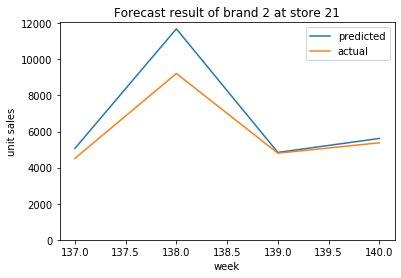

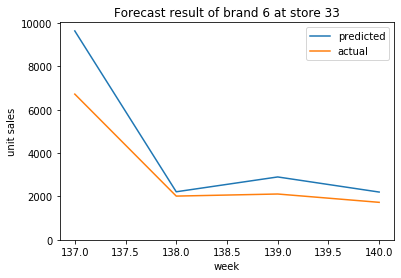

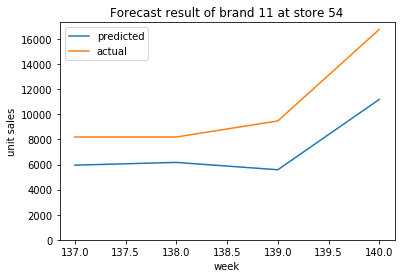

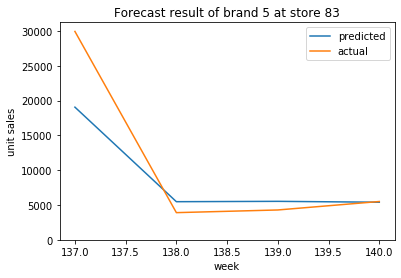

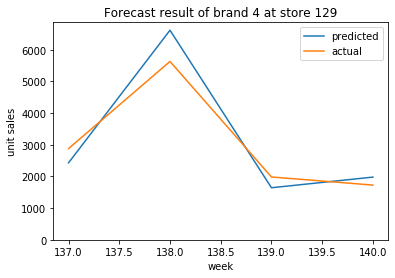

In [14]:
# Visualize forecast results
# import matplotlib.pyplot as plt
%matplotlib inline

random.seed(2)
results = pd.concat(combined_all, axis=0)
for _ in range(5):
    store = random.choice(results["store"].unique())
    brand = random.choice(results["brand"].unique())
    plot_result(results, store, brand)

## Additional Reading

\[1\] Aaron van den Oord, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. 2016. WaveNet: A Generative Model for Raw Audio. arXiv preprint
arXiv:1609.03499 (2016)<br>

\[2\] Shaojie Bai, J. Zico Kolter, and Vladlen Koltun. 2018. An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling. arXiv preprint arXiv:1803.01271 (2018)<br>